# Import the library

In [1]:
# Install BiMLPA: Community Detection in Bipartite Networks by Multi-Label Propagation
! pip install bimlpa
# for machine learning
! pip install node2vec
! pip install stellargraph
! pipn install Word2Vec

/bin/bash: pipn: command not found


In [2]:
import os
import math
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
from networkx.algorithms import bipartite
import numpy as np
from bipartiteLouvainMaster.src.new_bilouvain import new_bilouvain
from bipartiteLouvainMaster.src.bigraph import BiGraph
from BiMLPA import *
from sklearn.model_selection import train_test_split
from stellargraph import StellarGraph
from stellargraph.data import BiasedRandomWalk
from stellargraph.data import UnsupervisedSampler
from stellargraph.data import BiasedRandomWalk
from stellargraph.mapper import Node2VecLinkGenerator, Node2VecNodeGenerator
from stellargraph.layer import Node2Vec, link_classification

from stellargraph import datasets
from IPython.display import display, HTML

# Import the dataset

In [3]:
nodes_names = pd.DataFrame()
G = generate_network("data/out.github")
print("Is the graph bipartite", bipartite.is_bipartite(G))

Is the graph bipartite True


In [4]:
repository_names = pd.read_csv('data/ent.github.repository.name', names=['repository'], header=None)
nodes_names[['users', 'projects']] = repository_names.repository.str.split('/', 1, expand=True)
nodes_names['name'] = repository_names.index+1

In [5]:
def graph_description(graph):
  """
  Describe a graph

  Parameters
  ------------
  graph: Networkx graph
  """   
  print("Connected:", nx.is_connected(graph))
  print("Mean clustering coefficient:", round(nx.average_clustering(graph),4))
  print("Density:", round(nx.density(graph),4))
  print("Isolated Nodes:", len(list(nx.isolates(graph))))  
  print('-' * 40)
  print(nx.info(graph))
  print("The number of connected components:", nx.number_connected_components(graph))
  print('\n'*2)
    
graph_description(G)
#get nodes
g_users_nodes = {n for n, d in G.nodes(data=True) if d["bipartite"] == 0}
g_projects_nodes = {n for n, d in G.nodes(data=True) if d["bipartite"] == 1}
print("The number of users:", len(g_users_nodes))
print("The number of projects:", len(g_projects_nodes))
print("The bipartite density of users: ", bipartite.density(G, g_users_nodes))
print("The bipartite density of projects: ", bipartite.density(G, g_projects_nodes))

Connected: False
Mean clustering coefficient: 0.0
Density: 0.0
Isolated Nodes: 0
----------------------------------------
Graph with 177386 nodes and 440237 edges
The number of connected components: 15067



The number of users: 56519
The number of projects: 120867
The bipartite density of users:  6.444427294027613e-05
The bipartite density of projects:  6.444427294027613e-05


The othes subgraphs {0: 139752, 1: 45, 2: 36, 3: 34, 4: 29, 5: 27, 6: 22, 7: 21, 8: 20, 9: 20, 10: 20, 11: 20, 12: 20, 13: 20, 14: 20, 15: 19, 16: 18, 17: 18, 18: 18, 19: 17, 20: 17, 21: 17, 22: 16, 23: 16, 24: 16, 25: 16, 26: 16, 27: 16, 28: 16, 29: 16, 30: 15, 31: 15, 32: 15, 33: 15, 34: 15, 35: 15, 36: 15, 37: 15, 38: 14, 39: 14, 40: 14, 41: 14, 42: 14, 43: 14, 44: 14, 45: 14, 46: 14, 47: 14, 48: 14, 49: 13, 50: 13, 51: 13, 52: 13, 53: 13, 54: 13, 55: 13, 56: 13, 57: 13, 58: 13, 59: 13, 60: 13, 61: 12, 62: 12, 63: 12, 64: 12, 65: 12, 66: 12, 67: 12, 68: 12, 69: 12, 70: 12, 71: 12, 72: 12, 73: 11, 74: 11, 75: 11, 76: 11, 77: 11, 78: 11, 79: 11, 80: 11, 81: 11, 82: 11, 83: 11, 84: 11, 85: 11, 86: 11, 87: 11, 88: 11, 89: 11, 90: 11, 91: 11, 92: 11, 93: 11, 94: 11, 95: 11, 96: 11, 97: 11, 98: 10, 99: 10, 100: 10, 101: 10, 102: 10, 103: 10, 104: 10, 105: 10, 106: 10, 107: 10, 108: 10, 109: 10, 110: 10, 111: 10, 112: 10, 113: 10, 114: 10, 115: 10, 116: 10, 117: 10, 118: 10, 119: 10, 120: 

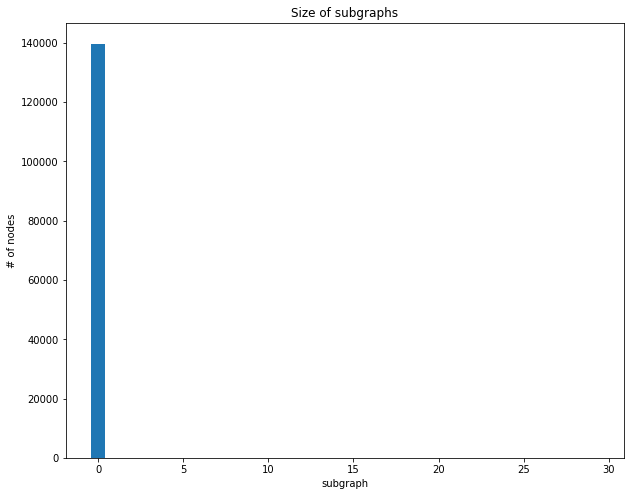

In [6]:
# we get the list of diconnected subgraphs ordered by their size
subgraphs = sorted(nx.connected_components(G), key=len, reverse=True)
size_subgraph = {}

for i, g in enumerate(subgraphs):
  size_subgraph[i] = len(G.subgraph(g))

fig, ax = plt.subplots(figsize=(10,8))
plt.bar(list(size_subgraph.keys())[: 30], list(size_subgraph.values())[:30])
plt.ylabel('# of nodes')
plt.xlabel('subgraph')
plt.title("Size of subgraphs")
print("The othes subgraphs", size_subgraph)

# Community detection in the graph using the bipartite louvain algorithm

In [7]:
# The ratio of users and projects in communities detected
sub_graphs = []
nb_users = {}
nb_projects = {}
partitions = []

# copy the graph and set label for the algorithm
tmp_G = G.copy()
tmp_G.add_nodes_from(g_users_nodes, color='red')
tmp_G.add_nodes_from(g_projects_nodes, color="blue")

# we get the list of diconnected subgraphs
list_subgraphs = sorted(nx.connected_components(tmp_G), key=len, reverse=True)
bimodularity_list = []

In [8]:
# get the communities for each subgraph

for i, g in enumerate(list_subgraphs):  
  bigraph = BiGraph()
  graph = tmp_G.subgraph(g)
  bigraph.build_init_bigraph(graph)
  # we get the partitions
  bimodularity, partition = new_bilouvain(bigraph)
  bimodularity_list.append(bimodularity) # append bimodularity
  partitions.append(max(partition.values())+1)# append partition
  communities = pd.Series(partition)
  nb_users[i] = {}
  nb_projects[i] = {}
  for comm_id in range(max(partition.values())+1):
    tmp_graph = graph.subgraph(communities[communities == comm_id].index)
    tmp_users = {n for n, d in tmp_graph.nodes(data=True) if d["bipartite"] == 0}
    tmp_projects = {n for n, d in tmp_graph.nodes(data=True) if d["bipartite"] == 1}
    nb_users[i][comm_id] = len(tmp_users)
    nb_projects[i][comm_id] = len(tmp_projects)
    sub_graphs.append(tmp_graph)

print("The number of partitions:", len(sub_graphs))


The number of partitions: 37394


In [9]:
# we select the statitics of the biggest subgraph
print("The number of users in each sugraph community:")
print(pd.Series(nb_users[0]).sort_values(ascending=False))
print("\n\nThe number of projects in each sugraph community:")
print(pd.Series(nb_projects[0]).sort_values(ascending=False))

The number of users in each sugraph community:
7       7820
2       6261
6       2028
25      1589
21      1416
        ... 
1260       1
1261       1
1262       1
1263       1
2488       1
Length: 2489, dtype: int64


The number of projects in each sugraph community:
2       13780
7       13557
6        7386
25       6613
21       4029
        ...  
1177        1
2058        1
2057        1
1181        1
2488        1
Length: 2489, dtype: int64


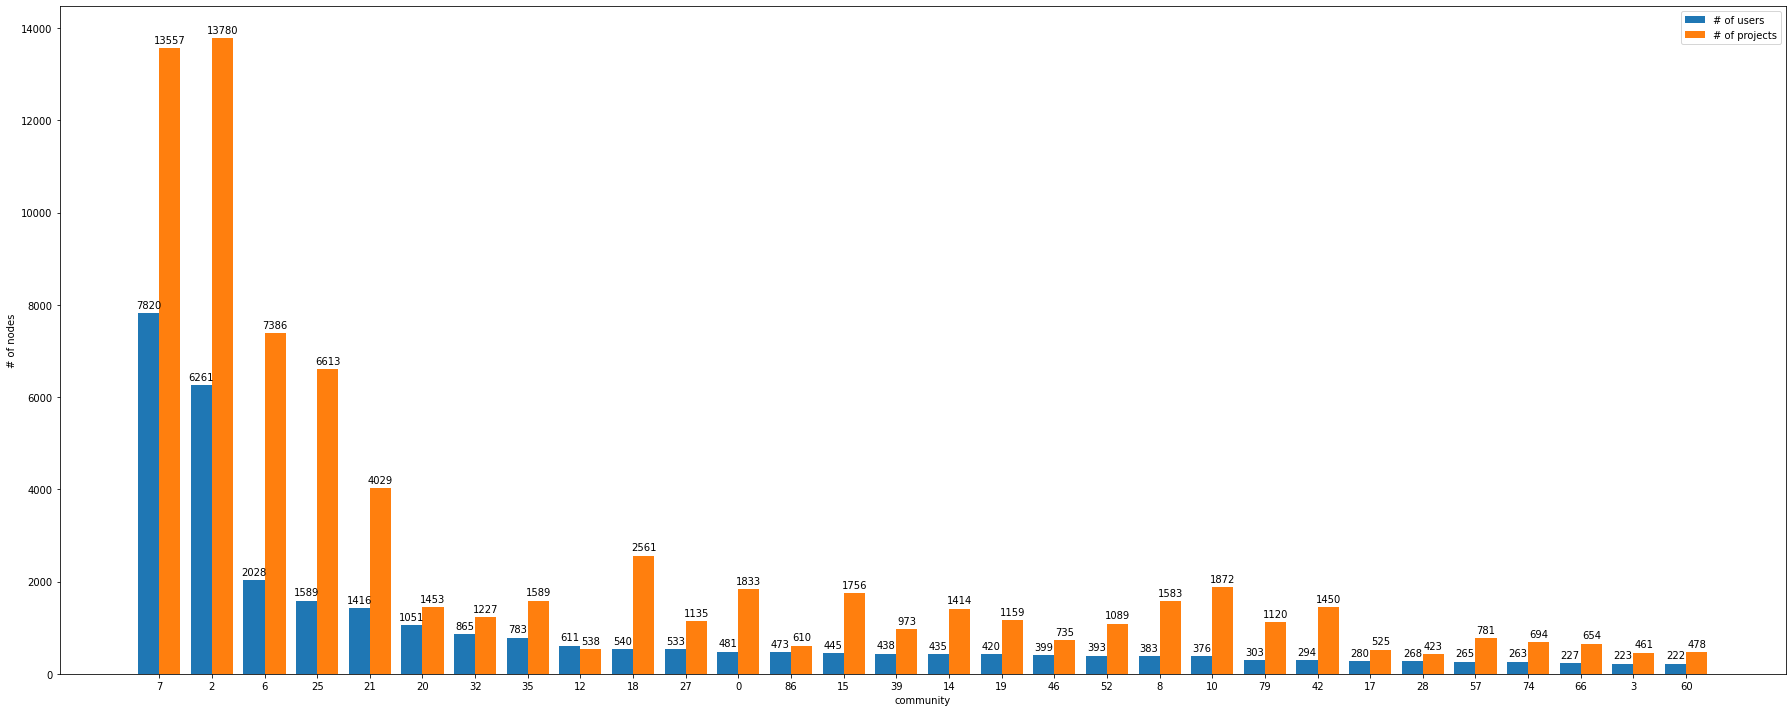

In [10]:
# for each community, the number of users and projects
nb_users_ordered = pd.Series(nb_users[0]).sort_values(ascending=False)
comm_users_ordered = nb_users_ordered.keys()

fig, ax = plt.subplots(figsize=(25,10))
communities_list = list(comm_users_ordered)[:30]
users_list = list(nb_users[0][u] for u in communities_list)
projects_list = list(nb_projects[0][p] for p in communities_list)
X_axis = np.arange(len(communities_list))

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        plt.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

rects1 = plt.bar(X_axis-0.2, users_list, 0.4, label="# of users")
rects2 = plt.bar(X_axis+0.2, projects_list, 0.4, label='# of projects')

plt.xticks(X_axis, communities_list)
plt.ylabel('# of nodes')
plt.xlabel('community')
plt.legend()

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()

In [11]:
print("for each subgraph the number of communities for each subgraph")
# plot it will not get much informations beacause of the number of communities in the largest subgraph
partitions

for each subgraph the number of communities for each subgraph


[2489,
 2,
 6,
 6,
 5,
 7,
 22,
 4,
 3,
 3,
 3,
 20,
 4,
 20,
 2,
 3,
 18,
 7,
 3,
 4,
 4,
 3,
 4,
 3,
 16,
 16,
 3,
 2,
 4,
 4,
 4,
 3,
 4,
 2,
 15,
 4,
 5,
 4,
 14,
 4,
 3,
 14,
 4,
 2,
 3,
 2,
 3,
 3,
 2,
 2,
 3,
 4,
 2,
 2,
 3,
 2,
 3,
 2,
 13,
 5,
 5,
 12,
 2,
 12,
 4,
 12,
 4,
 2,
 3,
 2,
 3,
 3,
 3,
 11,
 3,
 3,
 11,
 4,
 3,
 2,
 4,
 11,
 2,
 11,
 2,
 3,
 3,
 3,
 11,
 5,
 11,
 11,
 4,
 11,
 5,
 3,
 3,
 2,
 4,
 2,
 10,
 3,
 4,
 3,
 2,
 3,
 2,
 3,
 3,
 3,
 5,
 4,
 10,
 10,
 3,
 2,
 10,
 4,
 10,
 2,
 10,
 10,
 10,
 10,
 3,
 2,
 4,
 2,
 2,
 3,
 10,
 2,
 9,
 2,
 3,
 9,
 2,
 9,
 2,
 3,
 9,
 3,
 2,
 3,
 9,
 9,
 4,
 9,
 2,
 2,
 9,
 3,
 9,
 9,
 2,
 9,
 2,
 2,
 2,
 9,
 2,
 2,
 2,
 3,
 9,
 9,
 9,
 3,
 3,
 2,
 8,
 8,
 8,
 3,
 3,
 8,
 8,
 2,
 8,
 2,
 2,
 3,
 3,
 3,
 2,
 8,
 2,
 8,
 8,
 3,
 3,
 4,
 3,
 8,
 8,
 4,
 8,
 8,
 4,
 3,
 2,
 8,
 8,
 3,
 8,
 3,
 8,
 2,
 2,
 2,
 2,
 8,
 3,
 3,
 8,
 2,
 2,
 8,
 2,
 2,
 3,
 8,
 4,
 8,
 2,
 3,
 8,
 3,
 8,
 2,
 8,
 2,
 7,
 7,
 3,
 7,
 3,
 7,
 3,
 3,
 7,
 3

# Community Detection in Bipartite Networks by Multi-Label Propagation

In [12]:
users_communities = {}
projects_communities = {}
communities = []

for i, g in enumerate(list_subgraphs):  
  graph = tmp_G.subgraph(g)
  bimlpa = BiMLPA_SqrtDeg(graph, 0.3, 7)
  bimlpa.start()
  relabeling(graph)
  users_coms, projects_coms = output_community(graph)
  users_communities[i] = users_coms
  projects_communities[i] = projects_coms
  communities.append(graph)


In [13]:
print("The the number of cummunities of the biggest subgraph:", number_of_communities(communities[0]))
print("the mmodularity observed of the biggest subgraph:", murata_modularity(communities[0]))

The the number of cummunities of the biggest subgraph: (13365, 12110)
the mmodularity observed of the biggest subgraph: 0.580552967894892


The statistics of the biggest subgraph


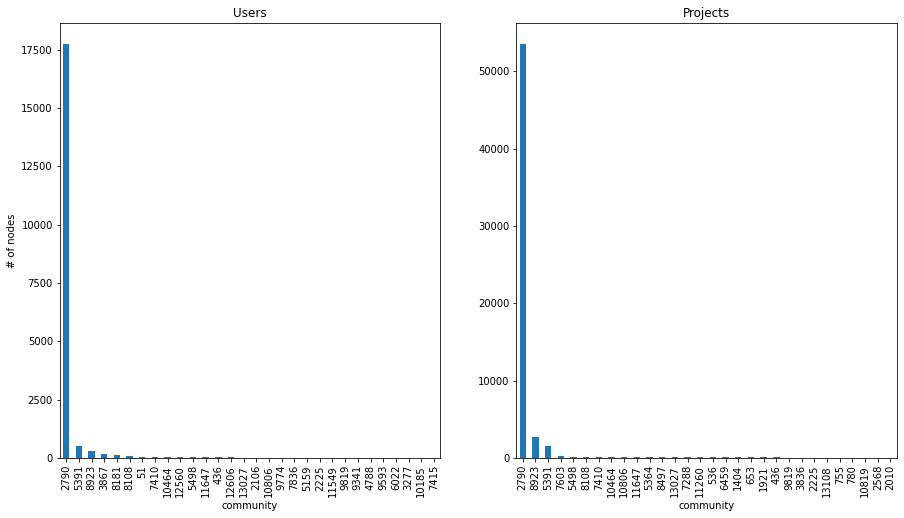

In [14]:
print("The statistics of the biggest subgraph")
users_label = {n: d['label'] for n, d in communities[0].nodes(data=True) if d['bipartite'] == 0}
projects_label = {n: d['label'] for n, d in communities[0].nodes(data=True) if d['bipartite'] == 1}

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,8))
u_communities = pd.Series(users_label)
plt.subplot(121)
plt.ylabel("# of nodes")
plt.xlabel("community")
plt.title("Users")
u_communities.value_counts().sort_values(ascending=False)[:30].plot.bar()
p_communities = pd.Series(projects_label)
plt.subplot(122)
plt.xlabel("community")
plt.title("Projects")
p_communities.value_counts().sort_values(ascending=False)[:30].plot.bar()

# Unsupervised Machine Learning

## Data Preprocessing

In [15]:
# Select two subgraphs
tmp1 = sub_graphs[communities_list[4]] # peek the 5th largest community of the largest subgraph
tmp2 = sub_graphs[communities_list[10]] # peek the 11th largest community of the largest subgraph

#We join 2 subgraphs
F = nx.compose(tmp1, tmp2)

# transform the graph to steallgraph
stella_graph = StellarGraph.from_networkx(F)
# Create the random walker
rw = BiasedRandomWalk(stella_graph)

walks = rw.run(
    nodes=list(stella_graph.nodes()),  # root nodes
    length=50,  # maximum length of a random walk
    n=10,  # number of random walks per root node
    p=0.5,  # Defines probability, 1/p, of returning to source node
    q=2.0,  # Defines probability, 1/q, for moving away from source node
)
print("Number of random walks: {}".format(len(walks)))


Number of random walks: 71130


In [16]:
from gensim.models import Word2Vec

# Representation of each node as vectors using Word2vec
str_walks = [[str(n) for n in walk] for walk in walks]
# we set the dimension to 128 with the attribute size
model = Word2Vec(str_walks, size=128, window=5, min_count=0, sg=1, workers=2, iter=1)

# Retrieve node embeddings and corresponding subjects
node_ids = model.wv.index2word  # list of node IDs
node_embeddings = (
    model.wv.vectors
) 

## Creation of the model

In [17]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

x = node_embeddings
# Reduce the dimensions using PCA
pca_3 = PCA(n_components=3)
x_reduced = pca_3.fit_transform(x)
print('Explained variation per principal component: {}'.format(pca_3.explained_variance_ratio_))

# We create a model
kmeans_model = KMeans(n_clusters=2)

y_pred = kmeans_model.fit_predict(x_reduced)

Explained variation per principal component: [0.10161072 0.08472438 0.05536379]


Text(0.5, 0.92, 'Number of Clusters: 2')

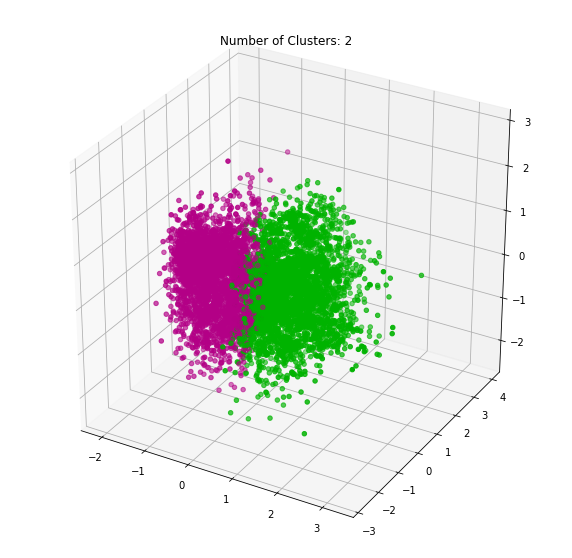

In [18]:
# we plot the clusters
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')

colors = np.array(["#00b300", "#b30086"])
ax.scatter(x_reduced[:, 0], x_reduced[:, 1], x_reduced[:, 2], color=colors[y_pred])
plt.title("Number of Clusters: 2")